In [1]:
# ============================
# PART 0 — Installs & Imports
# ============================
!pip -q install lightgbm xgboost nltk

import re, string, gc, numpy as np, pandas as pd
from scipy import sparse
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt

# NLTK resources
import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.tokenize import word_tokenize

RNG = 42
np.random.seed(RNG)


In [8]:
nltk.download('punkt_tab', quiet=True)

True

In [4]:
# SECTION 1: Mount Google Drive & Load Dataset
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
# ======================================
# PART 1 — Load Data & Basic Cleaning
# ======================================
# Set your file path here
FILE_PATH = '/content/drive/MyDrive/THESIS 47/Saved Datasets/[Suitable for FS] All_languages_200k_data_save.csv'
df = pd.read_csv(FILE_PATH)

# Keep only needed columns if present (robust to schema differences)
wanted_cols = [
    'title','reviewText','genre','language','language_encoded','director','director_encoded',
    'id_encoded','reviewId_encoded','originalScore','audienceScore','tomatoMeter','runtimeMinutes',
    'sentiment_label'
]
df = df[[c for c in wanted_cols if c in df.columns]].copy()

# Drop rows missing the target or core text
df = df.dropna(subset=['sentiment_label','reviewText','title']).reset_index(drop=True)

# Ensure target is int {0,1}
df['sentiment_label'] = df['sentiment_label'].astype(int)

print("Shape after initial filtering:", df.shape)
df.head(3)


Shape after initial filtering: (198059, 10)


,title,reviewText,genre,language_encoded,director_encoded,originalScore,audienceScore,tomatoMeter,runtimeMinutes,sentiment_label
0,Nekrotronic,Ghostbusters meets The Matrix in this very ent...,"comedy, horror, sci-fi",10,300,4.0,6.6,3.9,99.0,0
1,Goodnight Mommy,Goodnight Mommy cannot avoid comparisons that ...,mystery & thriller,0,300,5.0,3.5,4.0,91.0,0
2,California Split,...a distressingly erratic endeavor that never...,"comedy, drama",0,40,7.5,8.3,8.7,108.0,1


In [9]:
# =========================================================
# PART 2 — Text Preprocessing (clean → lemmatize → stem*)
# =========================================================
STOPWORDS = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer = SnowballStemmer('english')

def basic_clean(text:str) -> str:
    text = str(text).lower()
    text = re.sub(r"http\S+|www\.\S+", " ", text)            # URLs
    text = re.sub(r"<.*?>", " ", text)                        # HTML tags
    text = re.sub(r"\d+", " ", text)                          # digits
    text = text.translate(str.maketrans("", "", string.punctuation))
    text = re.sub(r"\s+", " ", text).strip()
    return text

def preprocess(text:str, do_stem=False) -> str:
    text = basic_clean(text)
    tokens = [t for t in word_tokenize(text) if t not in STOPWORDS and len(t) > 2]
    # Lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    if do_stem:
        tokens = [stemmer.stem(t) for t in tokens]
    return " ".join(tokens)

# Clean text columns
df['reviewText_clean'] = df['reviewText'].apply(lambda s: preprocess(s, do_stem=False))
df['title_clean']      = df['title'].apply(lambda s: preprocess(s, do_stem=False))


In [10]:
# =========================================
# PART 3 — Train/Test Split (Stratified)
# =========================================
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=RNG, stratify=df['sentiment_label']
)
y_train = train_df['sentiment_label'].values
y_test  = test_df['sentiment_label'].values
print(train_df.shape, test_df.shape, "Pos rate:", y_train.mean().round(4))


(158447, 12) (39612, 12) Pos rate: 0.5007


In [11]:
# ==========================================================
# PART 4 — Encoders: TF-IDF / Multi-hot / Target Encodings
# ==========================================================
# ---------- Parameters  ----------
PARAMS = {
    "REVIEW_TFIDF_MAX": 2000,
    "TITLE_TFIDF_MAX":  400,
    "NGRAMS": (1,2),
    "TFIDF_DTYPE": np.float32
}

# ---------- TF-IDF  ----------
tfidf_review = TfidfVectorizer(max_features=PARAMS["REVIEW_TFIDF_MAX"],
                               ngram_range=PARAMS["NGRAMS"],
                               dtype=PARAMS["TFIDF_DTYPE"],
                               sublinear_tf=True)
Xtr_review = tfidf_review.fit_transform(train_df['reviewText_clean'])
Xte_review = tfidf_review.transform(test_df['reviewText_clean'])

tfidf_title = TfidfVectorizer(max_features=PARAMS["TITLE_TFIDF_MAX"],
                              ngram_range=PARAMS["NGRAMS"],
                              dtype=PARAMS["TFIDF_DTYPE"],
                              sublinear_tf=True)
Xtr_title = tfidf_title.fit_transform(train_df['title_clean'])
Xte_title = tfidf_title.transform(test_df['title_clean'])

print("TF-IDF review/title shapes:", Xtr_review.shape, Xtr_title.shape)

# ---------- Multi-hot: GENRE (comma-separated) ----------
def split_comma_series(s):
    return [x.strip() for x in str(s).split(',') if str(x).strip()]

mlb_genre = MultiLabelBinarizer()
train_genre_list = train_df['genre'].apply(split_comma_series)
Xtr_genre = mlb_genre.fit_transform(train_genre_list)
Xte_genre = mlb_genre.transform(test_df['genre'].apply(split_comma_series))

# ---------- Multi-hot / One-hot: LANGUAGE ----------
if 'language' in train_df.columns:
    mlb_lang = MultiLabelBinarizer()
    train_lang_list = train_df['language'].apply(split_comma_series)
    Xtr_lang = mlb_lang.fit_transform(train_lang_list)
    Xte_lang = mlb_lang.transform(test_df['language'].apply(split_comma_series))
else:
    # Fallback: if only encoded int exists
    lang_train = train_df['language_encoded'].astype(int).astype(str).apply(lambda s: [f"lang_{s}"])
    lang_test  = test_df['language_encoded'].astype(int).astype(str).apply(lambda s: [f"lang_{s}"])
    mlb_lang = MultiLabelBinarizer()
    Xtr_lang = mlb_lang.fit_transform(lang_train)
    Xte_lang = mlb_lang.transform(lang_test)

# ---------- Director: Frequency + K-fold Target Mean (leak-safe) ----------
def director_features(train_s:pd.Series, y:np.ndarray, test_s:pd.Series):
    s_train = train_s.fillna("Unknown").astype(str)
    s_test  = test_s.fillna("Unknown").astype(str)

    # Frequency (log1p)
    freq = s_train.value_counts()
    tr_freq = s_train.map(freq).fillna(0).astype(float)
    te_freq = s_test.map(freq).fillna(0).astype(float)
    tr_freq = np.log1p(tr_freq.values)[:, None]
    te_freq = np.log1p(te_freq.values)[:, None]

    # K-fold target encoding with global prior
    global_mean = y.mean()
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RNG)
    tr_te = np.zeros(len(s_train), dtype=np.float32)

    for tr_idx, val_idx in skf.split(np.zeros(len(y)), y):
        tr_part = s_train.iloc[tr_idx]
        y_part  = y[tr_idx]
        means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index==idx.name].mean())
        tr_te[val_idx] = s_train.iloc[val_idx].map(means).fillna(global_mean).values

    te_te = s_test.map(s_train.groupby(s_train).apply(lambda idx: y[s_train.index==idx.name].mean()))
    te_te = te_te.fillna(global_mean).astype(np.float32).values[:, None]

    return tr_freq.astype(np.float32), te_freq.astype(np.float32), tr_te[:, None], te_te


if 'director' in train_df.columns:
    dtr, dte, dtr_te, dte_te = director_features(train_df['director'], y_train, test_df['director'])
else:
    # turn numeric code into strings to avoid treating it as numeric magnitude
    dtr, dte, dtr_te, dte_te = director_features(train_df['director_encoded'].astype(str), y_train,
                                                 test_df['director_encoded'].astype(str))


TF-IDF review/title shapes: (158447, 2000) (158447, 400)


/tmp/ipython-input-2295586659.py:72: RuntimeWarning: Mean of empty slice.
  means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index==idx.name].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-2295586659.py:72: RuntimeWarning: Mean of empty slice.
  means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index==idx.name].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipython-input-2295586659.py:72: RuntimeWarning: Mean of empty slice.
  means = tr_part.groupby(tr_part).apply(lambda idx: y_part[tr_part.index==idx.name].mean())
/usr/local/lib/python3.12/dist-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp

In [12]:
# ==================================
# PART 5 — Numeric Features & Scale
# ==================================
numeric_cols = [c for c in ['originalScore','audienceScore','tomatoMeter','runtimeMinutes']
                if c in train_df.columns]

Xtr_num = train_df[numeric_cols].astype('float32').values if numeric_cols else np.zeros((len(train_df),0),dtype='float32')
Xte_num = test_df[numeric_cols].astype('float32').values  if numeric_cols else np.zeros((len(test_df),0),dtype='float32')

scaler = StandardScaler(with_mean=True, with_std=True)
if Xtr_num.shape[1] > 0:
    Xtr_num = scaler.fit_transform(Xtr_num).astype('float32')
    Xte_num = scaler.transform(Xte_num).astype('float32')

# (Optional) add identifiers if you want them considered (usually we drop)
id_cols = [c for c in ['id_encoded','reviewId_encoded'] if c in train_df.columns]
Xtr_ids = train_df[id_cols].astype('float32').values if id_cols else np.zeros((len(train_df),0),dtype='float32')
Xte_ids = test_df[id_cols].astype('float32').values  if id_cols else np.zeros((len(test_df),0),dtype='float32')


In [13]:
# ======================================
# PART 6 — Final Feature Matrix (dense)
# ======================================
# We'll keep everything dense (float32). Convert sparse TF-IDF to dense here.

def to_dense32(sps):
    return sps.astype(PARAMS["TFIDF_DTYPE"]).toarray()

Xtr = np.hstack([
    to_dense32(Xtr_review),
    to_dense32(Xtr_title),
    Xtr_genre.astype('float32'),
    Xtr_lang.astype('float32'),
    dtr, dtr_te,       # director freq + target-encoded
    Xtr_num,
    Xtr_ids
]).astype('float32')

Xte = np.hstack([
    to_dense32(Xte_review),
    to_dense32(Xte_title),
    Xte_genre.astype('float32'),
    Xte_lang.astype('float32'),
    dte, dte_te,       # director freq + target-encoded
    Xte_num,
    Xte_ids
]).astype('float32')

print("Final X shapes:", Xtr.shape, Xte.shape)

# Build feature names to support importance grouping
feat_names = []
feat_names += [f"reviewText_tfidf_{i}" for i in range(Xtr_review.shape[1])]
feat_names += [f"title_tfidf_{i}" for i in range(Xtr_title.shape[1])]
feat_names += [f"genre_{g}" for g in mlb_genre.classes_]
feat_names += [f"language_{g}" for g in mlb_lang.classes_]
feat_names += ["director_freq_log", "director_target_mean"]
feat_names += numeric_cols
feat_names += id_cols


Final X shapes: (158447, 2452) (39612, 2452)


In [14]:
# ======================================
# PART 7 — Train Models
# ======================================
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight='balanced',
    n_jobs=-1,
    random_state=RNG
)
rf.fit(Xtr, y_train)

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    n_jobs=-1,
    random_state=RNG,
    eval_metric='logloss',
    verbosity=0
)
xgb.fit(Xtr, y_train)

lgb = LGBMClassifier(
    n_estimators=400,
    learning_rate=0.1,
    num_leaves=63,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=RNG,
    # Silence LightGBM:
    verbose=-1,
    verbosity=-1
)
lgb.fit(Xtr, y_train)

# (Optional) quick check
print("RF:", rf.score(Xte, y_test))
print("XGB:", xgb.score(Xte, y_test))
print("LGB:", lgb.score(Xte, y_test))


RF: 0.934817732000404
XGB: 0.94009391093608


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


LGB: 0.9438806422296274


In [15]:
# =======================================================
# PART 8 — Importances → Grouped Importances → RANKING
# =======================================================
# Raw importances aligned with feat_names
rf_imp  = pd.Series(rf.feature_importances_, index=feat_names)
xgb_imp = pd.Series(xgb.feature_importances_, index=feat_names)
lgb_imp = pd.Series(lgb.feature_importances_, index=feat_names)

# Group map by prefixes / exact names
group_map = {}
for n in feat_names:
    if n.startswith("reviewText_tfidf_"):
        group_map[n] = "reviewText"
    elif n.startswith("title_tfidf_"):
        group_map[n] = "title"
    elif n.startswith("genre_"):
        group_map[n] = "genre"
    elif n.startswith("language_"):
        group_map[n] = "language"
    elif n in ["director_freq_log","director_target_mean"]:
        group_map[n] = "director"
    elif n in numeric_cols:
        group_map[n] = n  # keep each numeric as its own group
    else:
        group_map[n] = "identifiers_or_other"

def group_importances(imp: pd.Series) -> pd.Series:
    df_imp = imp.reset_index()
    df_imp.columns = ['feature','importance']
    df_imp['group'] = df_imp['feature'].map(group_map)
    return df_imp.groupby('group')['importance'].sum().sort_values(ascending=False)

rf_g  = group_importances(rf_imp)
xgb_g = group_importances(xgb_imp)
lgb_g = group_importances(lgb_imp)

ranking = pd.DataFrame({
    'RandomForest_Importance': rf_g,
    'XGBoost_Importance': xgb_g,
    'LightGBM_Importance': lgb_g
}).fillna(0.0)

# Ranks (lower is better)
for col in ['RandomForest_Importance','XGBoost_Importance','LightGBM_Importance']:
    ranking[col.replace('Importance','Rank')] = ranking[col].rank(ascending=False, method='min')

ranking['Combined_Rank'] = (ranking['RandomForest_Rank'] + ranking['XGBoost_Rank'] + ranking['LightGBM_Rank']) / 3.0
ranking = ranking.sort_values('Combined_Rank')

print("\n=== FINAL GROUPED FEATURE RANKING ===")
display(ranking.round(4))



=== FINAL GROUPED FEATURE RANKING ===


,RandomForest_Importance,XGBoost_Importance,LightGBM_Importance,RandomForest_Rank,XGBoost_Rank,LightGBM_Rank,Combined_Rank
group,,,,,,,
reviewText,0.3049,0.7124,18517,2.0,1.0,1.0,1.3333
originalScore,0.4877,0.1728,710,1.0,2.0,7.0,3.3333
title,0.0279,0.0689,1295,5.0,3.0,2.0,3.3333
tomatoMeter,0.0895,0.0076,1055,3.0,6.0,3.0,4.0000
genre,0.0220,0.0236,921,6.0,4.0,5.0,5.0000
audienceScore,0.0405,0.0004,769,4.0,9.0,6.0,6.3333
runtimeMinutes,0.0142,0.0009,940,7.0,8.0,4.0,6.3333
language,0.0063,0.0122,273,9.0,5.0,9.0,7.6667
director,0.0070,0.0011,320,8.0,7.0,8.0,7.6667


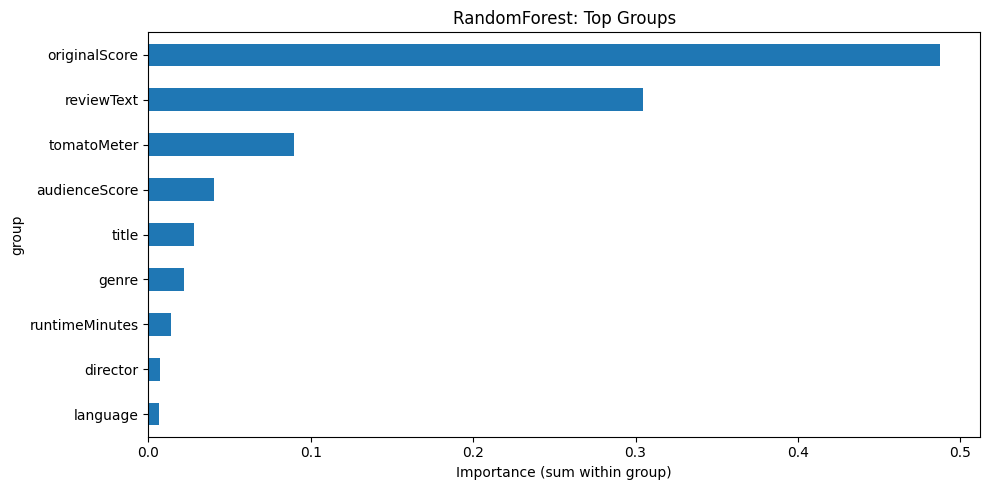

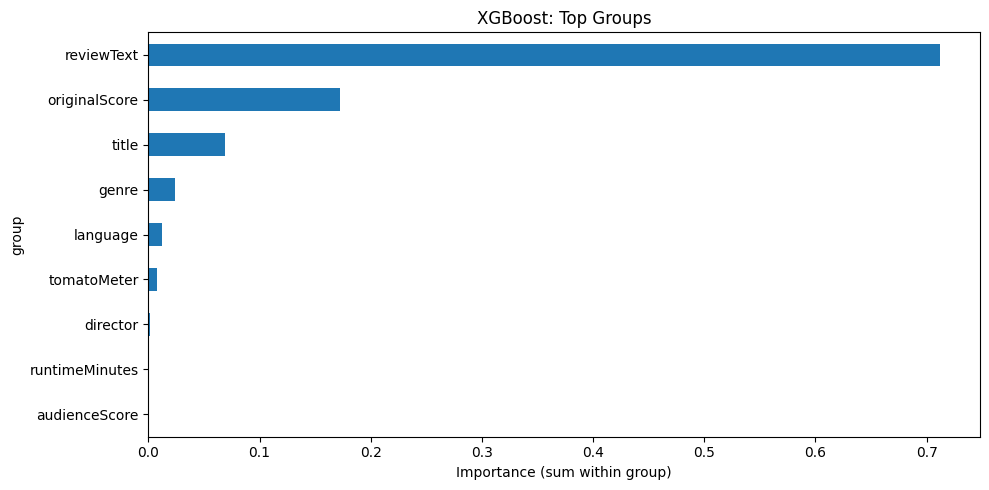

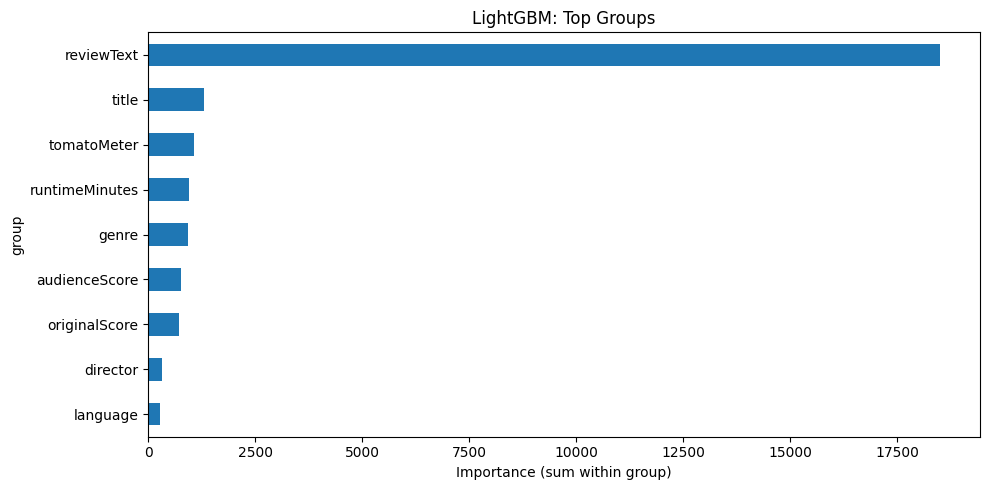

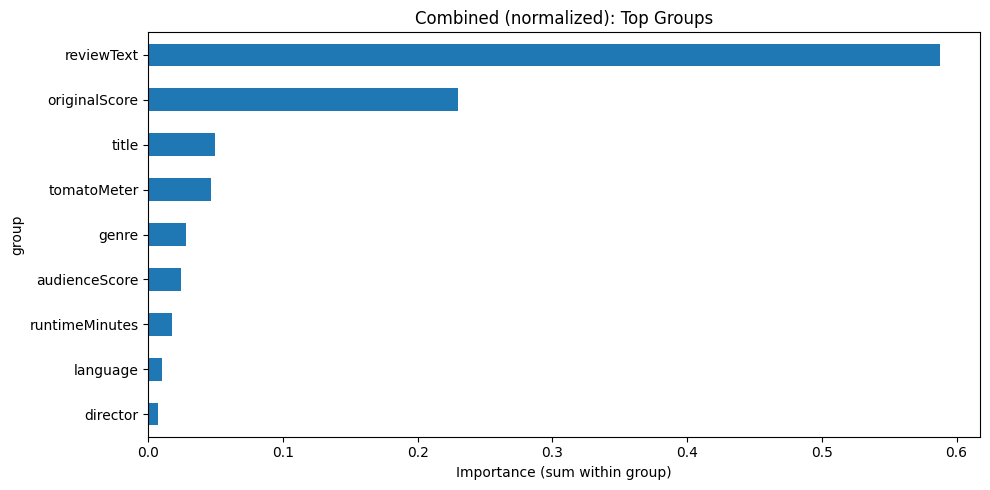

In [16]:
# ==================================
# PART 9 — Simple, Clean Bar Charts
#
# ==================================
TOP_N = 10

def plot_top(series, title):
    top = series.sort_values(ascending=False).head(TOP_N)
    plt.figure(figsize=(10,5))
    top[::-1].plot(kind='barh')  # barh with default color
    plt.title(title)
    plt.xlabel("Importance (sum within group)")
    plt.tight_layout()
    plt.show()

plot_top(rf_g,  "RandomForest: Top Groups")
plot_top(xgb_g, "XGBoost: Top Groups")
plot_top(lgb_g, "LightGBM: Top Groups")

# Combined (sum of normalized importances)
norm_rf  = rf_g / (rf_g.sum()  + 1e-9)
norm_xgb = xgb_g / (xgb_g.sum() + 1e-9)
norm_lgb = lgb_g / (lgb_g.sum() + 1e-9)
combined = (norm_rf + norm_xgb + norm_lgb) / 3.0
plot_top(combined, "Combined (normalized): Top Groups")


In [19]:
# ============================================
# PART 10 — Save Artifacts
# ============================================
# Save ranking table
OUT_RANK_CSV = '/content/drive/MyDrive/THESIS 47/Saved Models/Feature importance ranking/Ranking.csv'
ranking.to_csv(OUT_RANK_CSV)
print("Saved ranking to:", OUT_RANK_CSV)

# If you want to also save model .pkl files:
import joblib
joblib.dump(rf,  '/content/model_random_forest.pkl')
joblib.dump(xgb, '/content/model_xgboost.pkl')
joblib.dump(lgb, '/content/model_lightgbm.pkl')
print("Models saved to /content/*.pkl")


Saved ranking to: /content/drive/MyDrive/THESIS 47/Saved Models/Feature importance ranking/Ranking.csv
Models saved to /content/*.pkl
